# Deep Learning Fundamentals 13 - Custom Training 1

Welcome to another notebook on Deep Learning Fundamentals. In this notebook, we will visit a topic that I previously introduced but did not get into details, it is custom training. Firstly, we will create a basic custom training loop and understand the elements that we need to create one. Afterwards, we will create two custom training loops for toy datasets.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Firstly, let's create a model that estimates $w*x+b$.

In [3]:
class Model(object):
    def __init__(self):
    self.w = tf.Variable(2.0)
    self.b = tf.Variable(1.0)
    def __call__(self, x):
        return self.w * x + self.b
model = Model()

Let's also define the loss function.

In [4]:
def loss(predicted_y, target_y):
    return tf.reduce_mean(tf.square(predicted_y - target_y))

To train the model we need to calculate the gradients, and we will use GradientTape for that. Let's also briefly look at how GradientTape works.

In [1]:
def tf_gradient_tape(x):
    with tf.GradientTape() as t:
        t.watch(x)   

        y = 2*x**3-x**2+x

        z = tf.reduce_sum(y)
  
    dz_dx = t.gradient(z,x)    
    return dz_dx

In [6]:
# Check your function
tmp_x = tf.constant(2.0)
dz_dx = tf_gradient_tape(tmp_x)
result = dz_dx.numpy()
result

29.0

Now let's create some synthetic data and train our simple model.

In [7]:
TRUE_w = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000
xs  = tf.random.normal(shape=[NUM_EXAMPLES])
ys = (TRUE_w * xs) + TRUE_b

In [10]:
def plot_data(inputs, outputs, predicted_outputs):
    real = plt.scatter(inputs, outputs, c='b', marker='.')
    predicted = plt.scatter(inputs, predicted_outputs, c='r', marker='+')
    plt.legend((real,predicted), ('Real Data', 'Predicted Data'))
    plt.show()

In [ ]:
sns.set_theme()

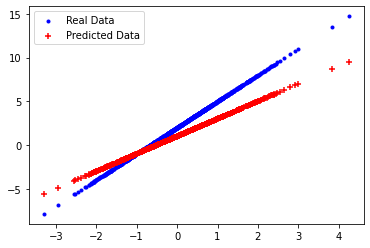

Current loss: 2.127325


In [11]:
plot_data(xs, ys, model(xs))
print('Current loss: %1.6f' % loss(model(xs), ys).numpy())

In [13]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
    dw, db = t.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)
    return current_loss

Now let's use the `train()` function above to train our model.

In [14]:
model = Model()

list_w, list_b = [], []
epochs = range(15)
losses = []
for epoch in epochs:
  list_w.append(model.w.numpy())
  list_b.append(model.b.numpy())
  current_loss = train(model, xs, ys, learning_rate=0.1)
  losses.append(current_loss)
  print('Epoch %2d: w=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, list_w[-1], list_b[-1], current_loss))

Epoch  0: w=2.00 b=1.00, loss=2.12733
Epoch  1: w=2.22 b=1.21, loss=1.31797
Epoch  2: w=2.39 b=1.37, loss=0.81673
Epoch  3: w=2.52 b=1.50, loss=0.50624
Epoch  4: w=2.63 b=1.60, loss=0.31387
Epoch  5: w=2.71 b=1.69, loss=0.19465
Epoch  6: w=2.77 b=1.75, loss=0.12075
Epoch  7: w=2.82 b=1.80, loss=0.07492
Epoch  8: w=2.86 b=1.84, loss=0.04650
Epoch  9: w=2.89 b=1.87, loss=0.02887
Epoch 10: w=2.92 b=1.90, loss=0.01793
Epoch 11: w=2.93 b=1.92, loss=0.01114
Epoch 12: w=2.95 b=1.94, loss=0.00692
Epoch 13: w=2.96 b=1.95, loss=0.00430
Epoch 14: w=2.97 b=1.96, loss=0.00268


That is it!! We created a very simple custom training loop. We can now simply use `model(X_test)` to get predictions. I will do that in the following example where we use some real data.

# Quadratic Layer with Custom Loop for MNIST

Above we created a model that estimates $y = ax + b$, in this part we will build a model that computes $y = ax^2 + bx + c$ and we will use this model on MNIST.

Let's load the data and get it ready.

In [29]:
import tensorflow_datasets as tfds
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteCY9J52/fashion_mnist-train.tfrecord*...:   0%|          | 0/60000…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteCY9J52/fashion_mnist-test.tfrecord*...:   0%|          | 0/10000 …

Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [30]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [31]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [32]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

Let's build our custom quadratic layer.

In [16]:
from tensorflow.keras.layers import Layer

class SimpleQuadratic(Layer):

    def __init__(self, units=32, activation=None):
        '''Initializes the class and sets up the internal variables'''
        super(SimpleQuadratic, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        a_init = tf.random_normal_initializer()
        a_init_val = a_init(shape=(input_shape[-1], self.units), dtype='float32')
        b_init = tf.random_normal_initializer()
        b_init_val = b_init(shape=(input_shape[-1], self.units), dtype='float32')
        c_init = tf.zeros_initializer()
        c_init_val = c_init(shape=(self.units,), dtype='float32')
        
        self.a = tf.Variable(initial_value = a_init_val, trainable=True)
        self.b = tf.Variable(initial_value = b_init_val, trainable=True)
        self.c = tf.Variable(initial_value = c_init_val, trainable=True)
        
    def call(self, inputs):
        '''Defines the computation from inputs to outputs'''
        x_squared = tf.math.square(inputs)
        x_squared_times_a = tf.matmul(x_squared, self.a)
        x_times_b = tf.matmul(inputs, self.b)
        x2a_plus_xb_plus_c = x_squared_times_a + x_times_b + self.c
        activated_x2a_plus_xb_plus_c = self.activation(x2a_plus_xb_plus_c)
        return activated_x2a_plus_xb_plus_c

Let's define the model and objects that we need during training. This time, I will also define a metric.

In [39]:
def base_model():
    inputs = tf.keras.Input(shape=(784,), name='digits')
    flatten=tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(flatten)
    x = SimpleQuadratic(128, activation='relu')(flatten)
    dropout=tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(dropout)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [40]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

Now it is time to define the functions we need for custom training.

In [41]:
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
  
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
   
    return logits, loss_value

def train_data_for_one_epoch():
    losses = []
    pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
        losses.append(loss_value)  
        train_acc_metric(y_batch_train, logits)
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()
    return losses

def perform_validation():
    losses = []
    for x_val, y_val in test:
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

Let's train the model.

In [44]:
from tqdm import tqdm
model = base_model()
# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
  
    losses_train = train_data_for_one_epoch()
    train_acc = train_acc_metric.result()

    losses_val = perform_validation()
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.2778: 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.5205  Validation Loss: 0.4435, Train Accuracy: 0.8187, Validation Accuracy 0.8464
Start of epoch 1


Training loss for step 937: 0.1955: 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.3812  Validation Loss: 0.4036, Train Accuracy: 0.8639, Validation Accuracy 0.8569
Start of epoch 2


Training loss for step 937: 0.5044: 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.3402  Validation Loss: 0.3714, Train Accuracy: 0.8771, Validation Accuracy 0.8673
Start of epoch 3


Training loss for step 937: 0.2731: 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.3114  Validation Loss: 0.3828, Train Accuracy: 0.8856, Validation Accuracy 0.8656
Start of epoch 4


Training loss for step 937: 0.1796: 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.2925  Validation Loss: 0.3492, Train Accuracy: 0.8925, Validation Accuracy 0.8771
Start of epoch 5


Training loss for step 937: 0.2481: 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.2741  Validation Loss: 0.3778, Train Accuracy: 0.8990, Validation Accuracy 0.8672
Start of epoch 6


Training loss for step 937: 0.2606: 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.2597  Validation Loss: 0.3488, Train Accuracy: 0.9043, Validation Accuracy 0.8805
Start of epoch 7


Training loss for step 937: 0.1973: 100%|██████████| 938/938 



 Epoch 7: Train loss: 0.2469  Validation Loss: 0.3624, Train Accuracy: 0.9071, Validation Accuracy 0.8735
Start of epoch 8


Training loss for step 937: 0.0863: 100%|██████████| 938/938 



 Epoch 8: Train loss: 0.2344  Validation Loss: 0.3719, Train Accuracy: 0.9126, Validation Accuracy 0.8755
Start of epoch 9


Training loss for step 937: 0.0807: 100%|██████████| 938/938 



 Epoch 9: Train loss: 0.2227  Validation Loss: 0.3437, Train Accuracy: 0.9170, Validation Accuracy 0.8829


The model performs better than I expected!!

# Human-vs-Horse Classification

Now we will move onto another dataset. I will use Tensorflow Datasets to load the data and Tensorflow HUB to load the model. The model will be a CNN network. I did not introduce CNNs yet, however, it is not that important since the idea here is to practice custom training loops.

In [45]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

  0%|          | 0/938 


Shuffling data/horses_or_humans/3.0.0.incompleteJT38LL/horses_or_humans-train.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling data/horses_or_humans/3.0.0.incompleteJT38LL/horses_or_humans-test.tfrecord*...:   0%|          | 0/…

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


Let's prepare the dataset.

In [46]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [47]:
@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224
    img = tf.image.resize(img,size=(image_height,image_width))
    img /= 255.0
    return img, label

In [49]:
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(buffer_size=num_examples).batch(batch_size)
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [50]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

Now let's load the model from Tensorflow HUB.

In [53]:
import tensorflow_hub as hub
MODULE_HANDLE = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Training loss for step 738: 0.3058:  79%|███████▉  | 739/938 


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


Let's load the metrics, loss, and the optimizer.

In [54]:
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

Let's build the functions that we need for custom training.

In [55]:
EPOCHS = 10
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = train_loss(y_true=y,y_pred=predictions)

    grads = tape.gradient(loss,model.trainable_variables)
    
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

    train_accuracy(y_true=y,y_pred=predictions)
    return loss

In [56]:
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            step += 1
            with tf.device(device_name=device):
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

Let's train the model.

In [57]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.623387218 ; train accuracy 0.625
Step 2 : train loss 0.464215249 ; train accuracy 0.6875
Step 3 : train loss 0.412895024 ; train accuracy 0.760416687
Step 4 : train loss 0.233771622 ; train accuracy 0.8046875
Step 5 : train loss 0.14603363 ; train accuracy 0.8375
Step 6 : train loss 0.128777087 ; train accuracy 0.864583313
Step 7 : train loss 0.124010265 ; train accuracy 0.879464269
Step 8 : train loss 0.0512061417 ; train accuracy 0.89453125
Step 9 : train loss 0.0719088539 ; train accuracy 0.90625
Step 10 : train loss 0.0541201346 ; train accuracy 0.915625
Step 11 : train loss 0.138272852 ; train accuracy 0.920454562
Step 12 : train loss 0.0297293812 ; train accuracy 0.927083313
Step 13 : train loss 0.0201979429 ; train accuracy 0.932692289
Step 14 : train loss 0.0198772419 ; train accuracy 0.9375
Step 15 : train loss 0.0140225869 ; train accuracy 0.941666663
Step 16 : train loss 0.00737988297 ; train accuracy 0.9453125
Step 17 : train loss 0.00915589277 ; train

Now let's show the training results.

In [58]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

In [59]:
class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    print(true_label)
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



0


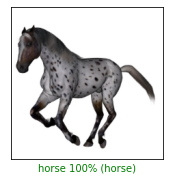

In [60]:
index = 7 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()